galとexについてpredict


## 変更

これをpbなしでやってみた

新しい特徴量  
'flux_ratio_sq':['sum','skew'],
'flux_by_flux_ratio_sq':['sum','skew'],
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean'] 

なんか分けたあともredshift系は有効なんやね
hostgal_photoz, err

最初のdetectedと最後のdetectedの差

## 結果

普通に下がった

gal 0.06060369472553572
ex 1.0930306404392172



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
import importlib
import time
import warnings
from joblib import dump, load

from cv_sampler import *

np.warnings.filterwarnings('ignore')


In [2]:

import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

ModuleNotFoundError: No module named 'tensorflow'

In [19]:
import load_data
importlib.reload(load_data)

<module 'load_data' from '/mnt/disks/ssd/project/new-lsst/scripts/load_data.py'>

In [4]:
raw_train_df = pd.read_csv('../input/training_set.csv')

In [5]:
train = raw_train_df.copy()
detected_groups = train[train['detected'] == 1].groupby('object_id')
detected_length = detected_groups['mjd'].max() - detected_groups['mjd'].min()
del train

In [6]:
%%time
df = raw_train_df.copy()

df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']

flux_all_dict = {
    "flux": ["min", "max", "mean", "median", "std", "skew"],
    "flux_err": ['min', 'max', 'mean', 'median', 'std','skew'],
    "detected": ["mean"],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew']
}

flux_all_feats = df.groupby('object_id').agg(flux_all_dict)
new_columns = [
    k + '_' + agg for k in flux_all_dict.keys() for agg in flux_all_dict[k]
]
flux_all_feats.columns = new_columns

flux_all_feats['detected_length'] = detected_length
del detected_length

flux_kurt = df.groupby('object_id').flux.apply(lambda x: x.kurtosis())
flux_all_feats['flux_kurtosis'] = flux_kurt

flux_all_feats[
    'flux_diff'] = flux_all_feats['flux_max'] - flux_all_feats['flux_min']

flux_all_feats['flux_abs_median'] = df.groupby('object_id').flux.apply(
    lambda x: x.abs().median())

flux_all_feats['flux_diff_dbmed'] = flux_all_feats[
    'flux_diff'] / flux_all_feats['flux_abs_median']
flux_all_feats['flux_max_dbmed'] = flux_all_feats[
    'flux_max'] / flux_all_feats['flux_abs_median']
flux_all_feats['flux_min_dbmed'] = flux_all_feats[
    'flux_min'] / flux_all_feats['flux_abs_median']

train_feature_df = flux_all_feats


CPU times: user 8.14 s, sys: 151 ms, total: 8.29 s
Wall time: 7.1 s


In [7]:
period_df = load_data.load_train_period()

concat_df = pd.concat([train_feature_df, period_df], axis=1)
meta_data = pd.read_csv('../input/training_set_metadata.csv')
meta_data.index = meta_data.object_id

meta_concat_df = pd.concat([concat_df, meta_data[['hostgal_photoz', 'hostgal_photoz_err']]], axis=1)

meta_concat_df.fillna(meta_concat_df.mean(), inplace=True)

In [8]:
gal_df, ex_df = load_data.cut_galaxy(meta_concat_df, meta_data)
gal_target, ex_target = load_data.cut_galaxy(meta_data.target, meta_data)

In [9]:
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)

0 Wed Dec 12 23:00:31 2018
10 Wed Dec 12 23:00:48 2018
20 Wed Dec 12 23:01:04 2018
30 Wed Dec 12 23:01:22 2018
40 Wed Dec 12 23:01:36 2018
50 Wed Dec 12 23:01:56 2018
60 Wed Dec 12 23:02:15 2018
70 Wed Dec 12 23:02:29 2018
80 Wed Dec 12 23:02:50 2018
90 Wed Dec 12 23:03:06 2018
0.06060369472553572
{'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'class_weight': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}, 'learning_rate': 0.048180721292855395, 'subsample': 0.8370321019295307, 'colsample_bytree': 0.638055167136259, 'reg_alpha': 0.003943872978357696, 'reg_lambda': 0.01849388412791642, 'min_split_gain': 0.005082739540358733, 'min_child_weight': 2.3281812406075275, 'min_child_samples': 40, 'n_estimators': 3372, 'max_depth': 3, 'num_leaves': 18, 'silent': True, 'n_jobs': -1}
[811, 404, 332]


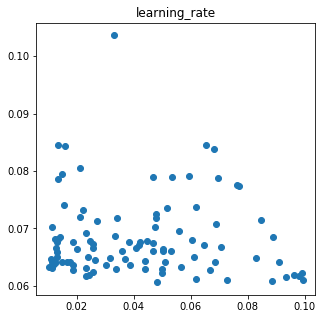

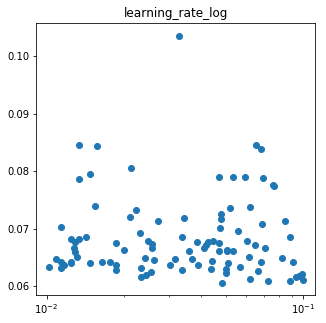

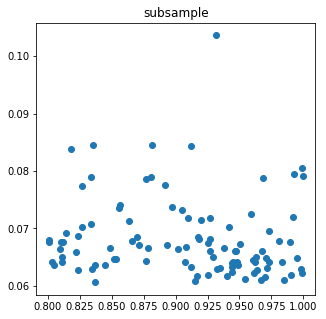

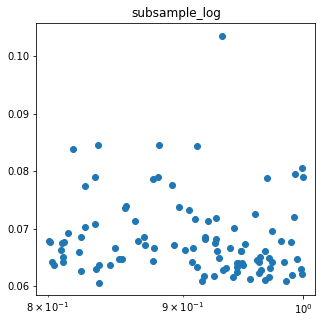

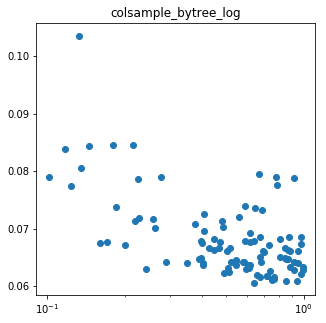

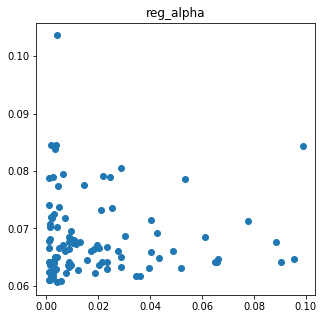

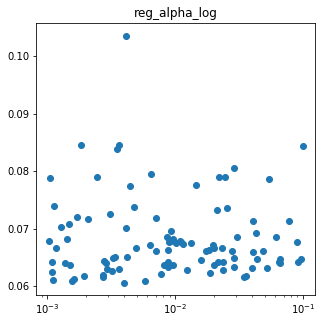

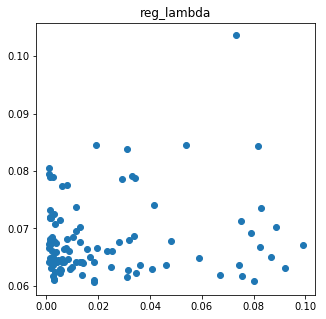

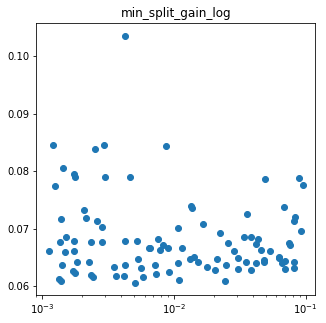

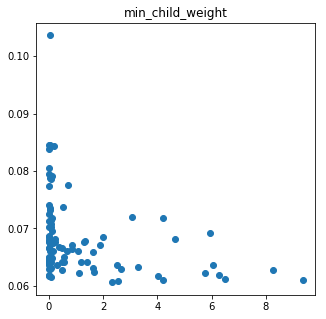

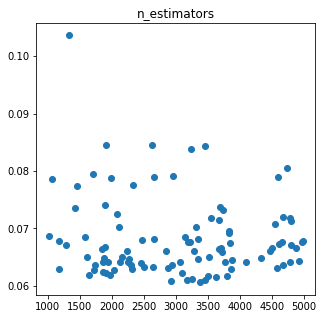

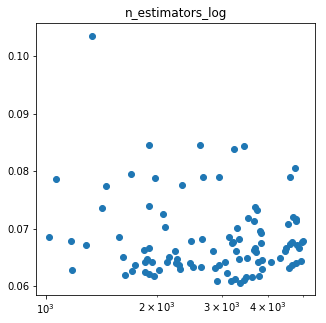

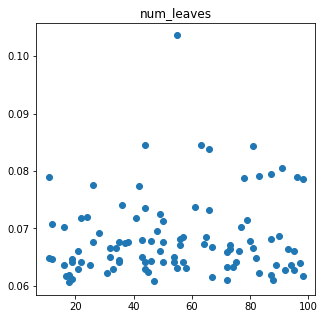

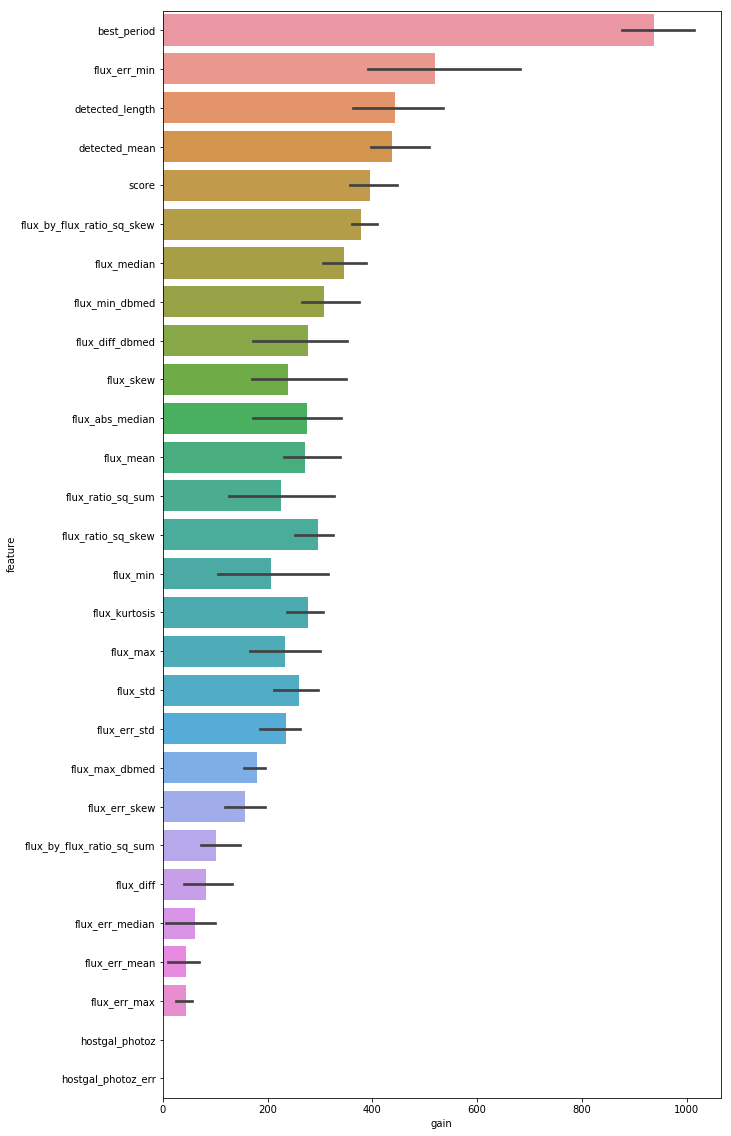

In [10]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.8, 1),
    'colsample_bytree': UniformSampler(0.1, 1.0),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(-3, 1),
    'min_child_samples': UniformSampler(1, 50, int),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 6, int),
    'num_leaves': UniformSampler(10, 100, int),
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
best_iteration_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    if i_seed % 10 == 0:
        print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'min_child_samples': param_samplers['min_child_samples'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'num_leaves': param_samplers['num_leaves'].rvs(),
        'silent': True,
        'n_jobs': -1
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    seed_early_stopping = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['seed_fold'] = i_seed * 10 + i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
        seed_early_stopping.append(gal_clf.best_iteration_)
        
    score_list.append(np.mean(seed_score_list))
    best_iteration_list.append(seed_early_stopping)


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'min_child_samples',
  'n_estimators',
  'max_depth',
  'num_leaves']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

best_id = np.argmin(score_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])

0 Wed Dec 12 23:03:27 2018
10 Wed Dec 12 23:05:04 2018
20 Wed Dec 12 23:06:30 2018
30 Wed Dec 12 23:07:33 2018
40 Wed Dec 12 23:09:07 2018
50 Wed Dec 12 23:10:18 2018
60 Wed Dec 12 23:11:50 2018
70 Wed Dec 12 23:13:36 2018
80 Wed Dec 12 23:14:54 2018
90 Wed Dec 12 23:16:26 2018
1.0930306404392172
{'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'class_weight': {0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1}, 'learning_rate': 0.01093303674741398, 'subsample': 0.9789426260519996, 'colsample_bytree': 0.5139041202754954, 'reg_alpha': 0.004099615818176204, 'reg_lambda': 0.01094733430445172, 'min_split_gain': 0.010247432750052627, 'min_child_weight': 0.0023763662813790594, 'min_child_samples': 34, 'n_estimators': 3973, 'max_depth': 16, 'num_leaves': 73, 'silent': True, 'n_jobs': -1}
[707, 802, 797]


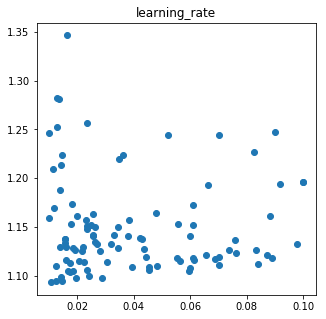

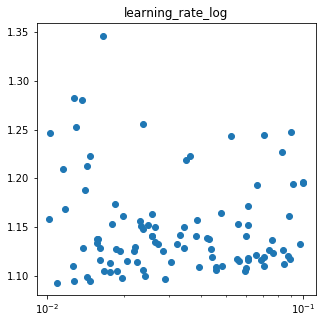

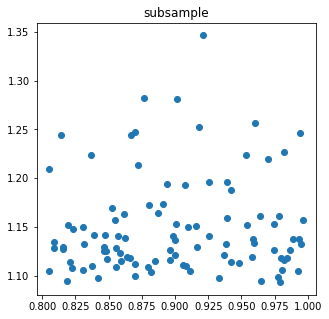

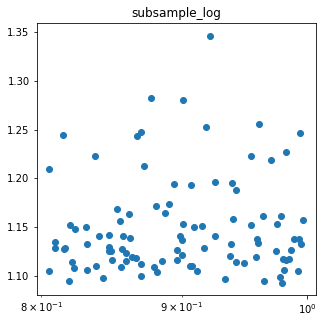

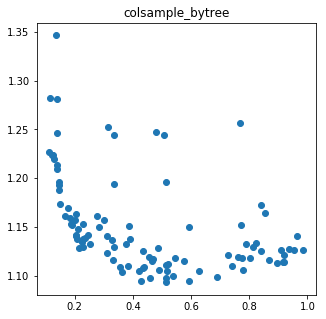

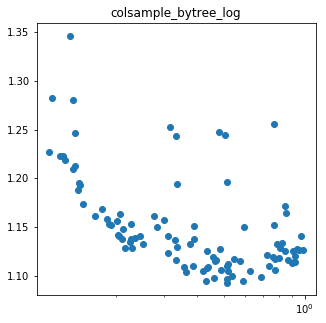

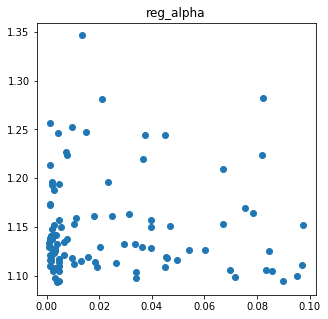

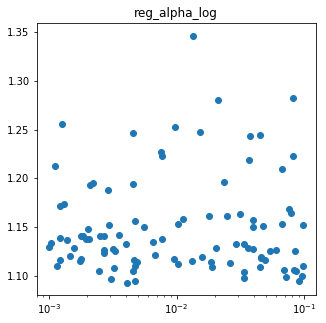

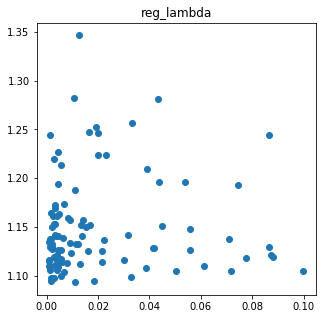

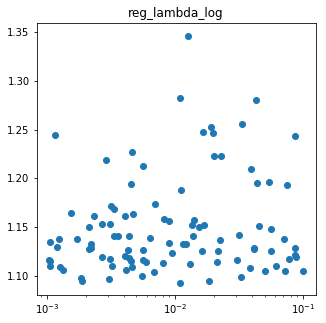

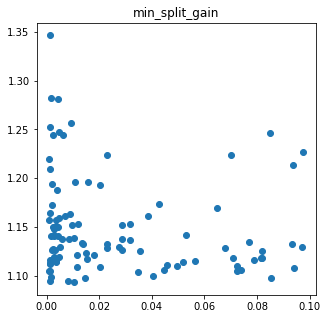

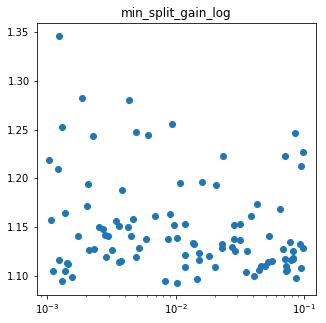

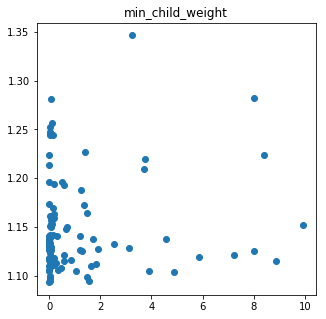

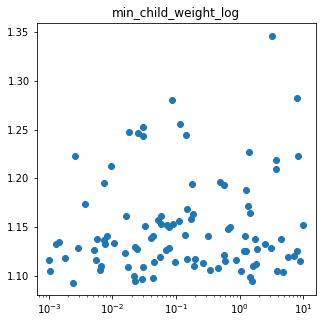

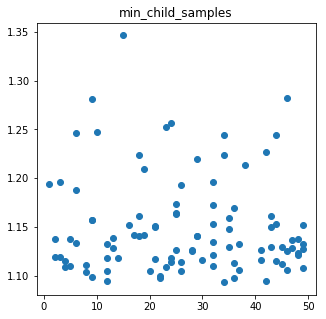

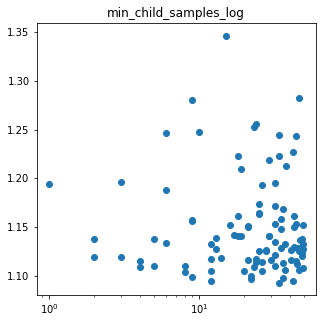

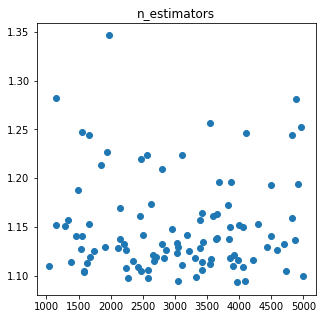

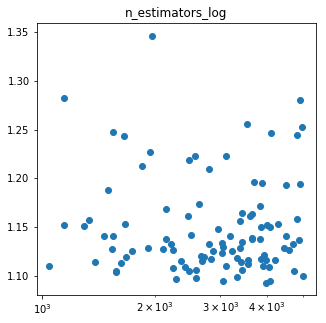

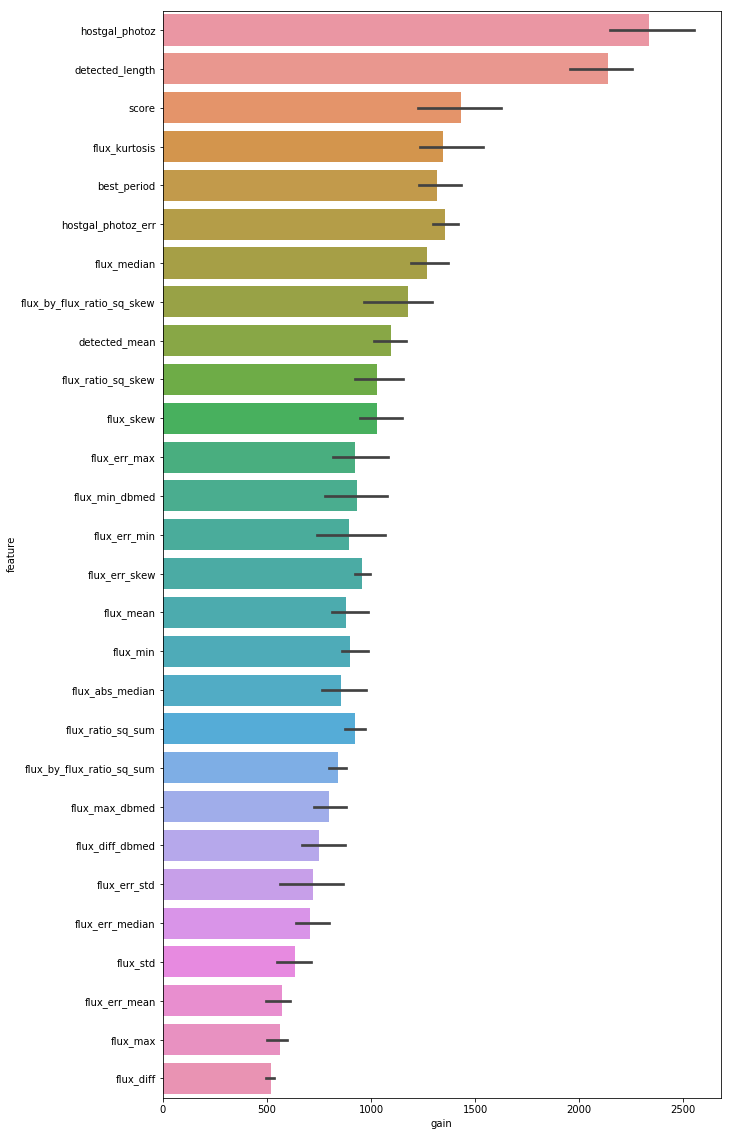

In [11]:
# extra galaxy
gal_df = ex_df
gal_target = ex_target
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.8, 1),
    'colsample_bytree': UniformSampler(0.1, 1.0),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(-3, 1),
    'min_child_samples': UniformSampler(1, 50, int),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 20, int),
    'num_leaves': UniformSampler(10, 100, int),
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
best_iteration_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    if i_seed % 10 == 0:
        print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'min_child_samples': param_samplers['min_child_samples'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'num_leaves': param_samplers['num_leaves'].rvs(),
        'silent': True,
        'n_jobs': -1
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    seed_early_stopping = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['seed_fold'] = i_seed * 10 + i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
        seed_early_stopping.append(gal_clf.best_iteration_)
        
    score_list.append(np.mean(seed_score_list))
    best_iteration_list.append(seed_early_stopping)


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'min_child_samples',
  'n_estimators',
  'max_depth',
  'num_leaves']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

best_id = np.argmin(score_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])

In [8]:
i_split = 1
raw_train_df = pd.read_csv(f'../proccesed-data/test_split_{i_split}.csv')

train = raw_train_df.copy()
detected_groups = train[train['detected'] == 1].groupby('object_id')
detected_length = detected_groups['mjd'].max() - detected_groups['mjd'].min()
del train

%%time
df = raw_train_df.copy()

df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']

flux_all_dict = {
    "flux": ["min", "max", "mean", "median", "std", "skew"],
    "flux_err": ['min', 'max', 'mean', 'median', 'std','skew'],
    "detected": ["mean"],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew']
}

flux_all_feats = df.groupby('object_id').agg(flux_all_dict)
new_columns = [
    k + '_' + agg for k in flux_all_dict.keys() for agg in flux_all_dict[k]
]
flux_all_feats.columns = new_columns

flux_all_feats['detected_length'] = detected_length
del detected_length

flux_kurt = df.groupby('object_id').flux.apply(lambda x: x.kurtosis())
flux_all_feats['flux_kurtosis'] = flux_kurt

flux_all_feats[
    'flux_diff'] = flux_all_feats['flux_max'] - flux_all_feats['flux_min']

flux_all_feats['flux_abs_median'] = df.groupby('object_id').flux.apply(
    lambda x: x.abs().median())

flux_all_feats['flux_diff_dbmed'] = flux_all_feats[
    'flux_diff'] / flux_all_feats['flux_abs_median']
flux_all_feats['flux_max_dbmed'] = flux_all_feats[
    'flux_max'] / flux_all_feats['flux_abs_median']
flux_all_feats['flux_min_dbmed'] = flux_all_feats[
    'flux_min'] / flux_all_feats['flux_abs_median']

train_feature_df = flux_all_feats


period_df = pd.read_csv(
    f'../proccesed-data/test_periods_split{i_split}.csv')

period_df.index = period_df.object_id
period_df.drop(columns=['object_id'], inplace=True)

concat_df = pd.concat([train_feature_df, period_df], axis=1)
meta_data = pd.read_csv('../input/test_set_metadata.csv', usecols=['object_id', 'hostgal_photoz', 'hostgal_photoz_err'])
meta_data.index = meta_data.object_id

meta_concat_df = pd.concat([concat_df, meta_data[['hostgal_photoz', 'hostgal_photoz_err']]], axis=1)

meta_concat_df.fillna(meta_concat_df.mean(), inplace=True)

In [23]:
gal_df, ex_df = load_data.cut_galaxy(meta_concat_df,
                                         meta_data.loc[meta_concat_df.index])

In [25]:
gal_df.describe()

flux_min      flux_max      flux_mean    flux_median  \
count  3.905100e+05  3.905100e+05  390510.000000  390510.000000   
mean  -9.724903e+02  1.330854e+03       8.981584     -15.590554   
std    1.085824e+04  1.227932e+04     124.983829      88.426851   
min   -5.289244e+06 -2.284962e+02  -27997.487166  -30098.544922   
25%   -9.069441e+02  1.244213e+03       8.862935     -14.324383   
50%   -9.069441e+02  1.244213e+03       8.862935     -14.324383   
75%   -9.069441e+02  1.244213e+03       8.862935     -14.324383   
max    4.016127e+00  4.169107e+06   20570.683198    6107.427734   

            flux_std      flux_skew   flux_err_min  flux_err_max  \
count  390510.000000  390510.000000  390510.000000  3.905100e+05   
mean      282.497693       0.953622       3.139394  9.979342e+02   
std      1804.693023       0.320617       2.528582  1.353656e+04   
min        13.079331     -12.051255       0.943530  3.323101e+01   
25%       264.097329       0.955485       3.034970  9.296532e+02   
50%       264.097329       0.955485       3.034970  9.296532e+02   
75%       264.097329       0.955485       3.034970  9.296532e+02   
max    691140.535903      12.211422     438.476105  4.752326e+06   

       flux_err_mean  flux_err_median         ...          flux_kurtosis  \
count  390510.000000    390510.000000         ...          390510.000000   
mean       60.252007        14.580092         ...               7.262307   
std       596.999528         8.996958         ...               2.779168   
min         9.525104         6.475631         ...              -1.547025   
25%        56.888548        14.262107         ...               7.199738   
50%        56.888548        14.262107         ...               7.199738   
75%        56.888548        14.262107         ...               7.199738   
max    200009.609659      2561.530273         ...             150.709695   

          flux_diff  flux_abs_median  flux_diff_dbmed  flux_max_dbmed  \
count  3.905100e+05    390510.000000    390510.000000   390510.000000   
mean   2.303345e+03       107.516948        29.980742       19.391475   
std    2.249733e+04       137.402888        15.884462       10.779343   
min    6.657845e+01         3.152352         0.501042       -0.667355   
25%    2.151157e+03       100.233627        29.876129       19.339867   
50%    2.151157e+03       100.233627        29.876129       19.339867   
75%    2.151157e+03       100.233627        29.876129       19.339867   
max    9.458351e+06     30098.544922      5970.424152     2843.535709   

       flux_min_dbmed    best_period          score  hostgal_photoz  \
count   390510.000000  390510.000000  390510.000000        390510.0   
mean       -10.589266      19.479161       0.477725             0.0   
std          7.700388       2.870936       0.030835             0.0   
min      -3338.745620       0.200012       0.010558             0.0   
25%        -10.536262      19.654691       0.476114             0.0   
50%        -10.536262      19.654691       0.476114             0.0   
75%        -10.536262      19.654691       0.476114             0.0   
max          0.002200     370.776024       0.992976             0.0   

       hostgal_photoz_err  
count            390510.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0  

[8 rows x 28 columns]

In [14]:
gal_clf = load('../models/gal_clf12201958.joblib')
ex_clf = load('../models/ex_clf12201958.joblib')


In [16]:
import submit

In [21]:
%%time
submit_df = submit.submit_scv(gal_clf, ex_clf, gal_df, ex_df)

ValueError: Number of features of the model must match the input. Model n_features_ is 100 and input n_features is 26 